In [ ]:
!pip install ta
!pip install hmmlearn

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=518d7d90d02f6f6b431a9b27248de284dfa889ba19c4f6d5ee8040ded3cacab5
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 3.0 MB/s eta 0:00:00


# Libraries

In [ ]:
#Libraries
import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import time

from ta.momentum import RSIIndicator
from statsmodels.tsa.stattools import ccf
from hmmlearn import hmm

# Data Collection

In [ ]:
start_date = datetime.date(2020, 1, 1)
end_date   = datetime.date(2024, 12, 31)
VOO        = yf.download(['VOO'], start_date, end_date)
VIX        = yf.download(['^VIX'], start_date, end_date)
VOO_close  = VOO[['Close']]
VIX_close  = VIX[['Close']]
print(VIX_close.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Price       Close
Ticker       ^VIX
Date             
2020-01-02  12.47
2020-01-03  14.02
2020-01-06  13.85
2020-01-07  13.79
2020-01-08  13.45


# Exploratory Data Analysis

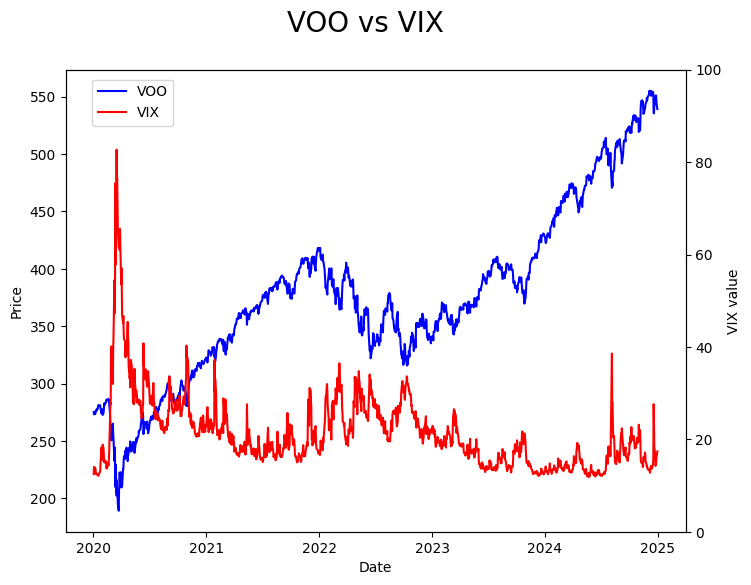

In [ ]:
df = pd.concat([VOO['Close'], VIX['Close']],axis=1)

fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()
ax2.set_ylim(0, 100)

# Plot lines with labels
ax1.plot(df.index, df['VOO'], color='b', label='VOO')
ax2.plot(df.index, df['^VIX'], color='r', label='VIX')

ax1.set_xlabel("Date")
ax1.set_ylabel("Price")
ax2.set_ylabel("VIX value")

fig.suptitle("VOO vs VIX", fontsize=20)

# Get legend handles and labels from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
handles = handles1 + handles2
labels = labels1 + labels2

# Create a single legend for the figure
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.15, 0.875))

# Display the plot
plt.show()


# Regime Analysis on the VIX level

<ipython-input-6-d6c75a8cbeb8>:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


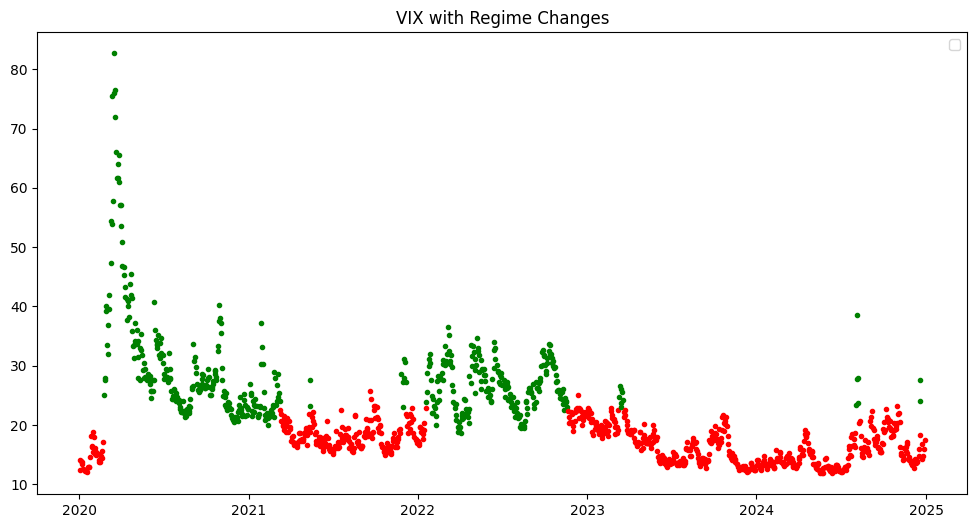

Mean VIX level for Regime 0: 21.636999320983886
Mean VIX level for Regime 1: 20.8700008392334


In [ ]:
vix_values = VIX_close['Close'].values  # Extract the values as a NumPy array

# Use the NumPy array for digitization
vix_discretized = np.digitize(vix_values, bins=np.linspace(vix_values.min(), vix_values.max(), 20))


# Reshape the data for HMM (required by the library)
vix_discretized = vix_discretized.reshape(-1, 1)

# Initialize and train the HMM model
model = hmm.GaussianHMM(n_components=2, covariance_type="diag", n_iter=10000)  # Adjust parameters as needed
model.fit(vix_discretized)


# Predict the most likely hidden states
hidden_states = model.predict(vix_discretized)

# Visualize regime changes (Optional)
plt.figure(figsize=(12, 6))

# Create a color map for the regimes
colors = ['green', 'red']  # Adjust colors as needed

for i, state in enumerate(hidden_states):
    plt.plot(VIX_close.index[i], VIX_close['Close'].iloc[i], color=colors[state], marker='o', markersize=3)

plt.title("VIX with Regime Changes")
plt.legend()
plt.show()

import numpy as np
# Calculate the mean VIX level for each regime
regime_0_vix_mean = np.percentile(VIX_close['Close'][hidden_states == 0],10)
regime_1_vix_mean = np.percentile(VIX_close['Close'][hidden_states == 1],90)

print(f"Mean VIX level for Regime 0: {regime_0_vix_mean}")
print(f"Mean VIX level for Regime 1: {regime_1_vix_mean}")


In [ ]:
df_returns = df
df_returns['VOO pct change'] = df_returns['VOO'].pct_change()
df_returns['VIX pct change'] = df_returns['^VIX'].pct_change()
df_returns = df_returns.dropna()
df_returns = df_returns.drop(columns = ['VOO', '^VIX'])
print(df_returns.head())

Ticker      VOO pct change  VIX pct change
Date                                      
2020-01-03       -0.007305        0.124298
2020-01-06        0.003747       -0.012126
2020-01-07       -0.002758       -0.004332
2020-01-08        0.005160       -0.024656
2020-01-09        0.006911       -0.067658


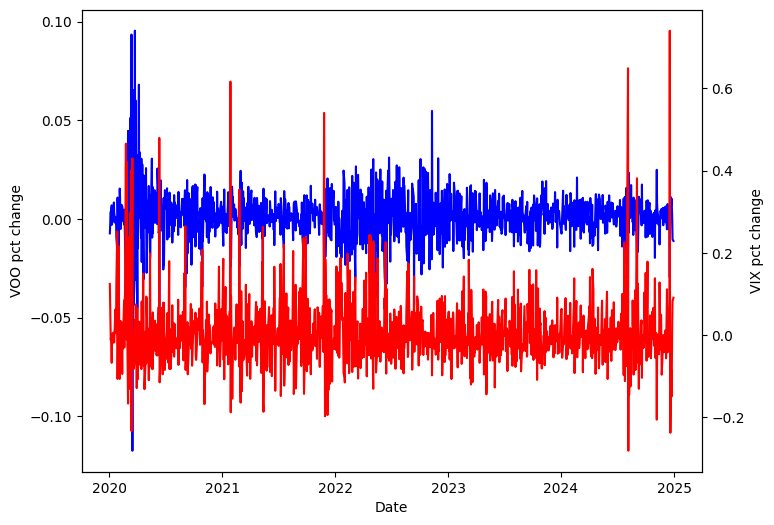

In [ ]:
ig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()
ax1.plot(df_returns.index,df_returns['VOO pct change'],color ='b')
ax2.plot(df_returns.index, df_returns['VIX pct change'],color = 'r')


ax1.set_xlabel("Date")
ax1.set_ylabel("VOO pct change")
ax2.set_ylabel("VIX pct change")

fig.suptitle("VOO vs VIX pct change", fontsize=12)
plt.show()

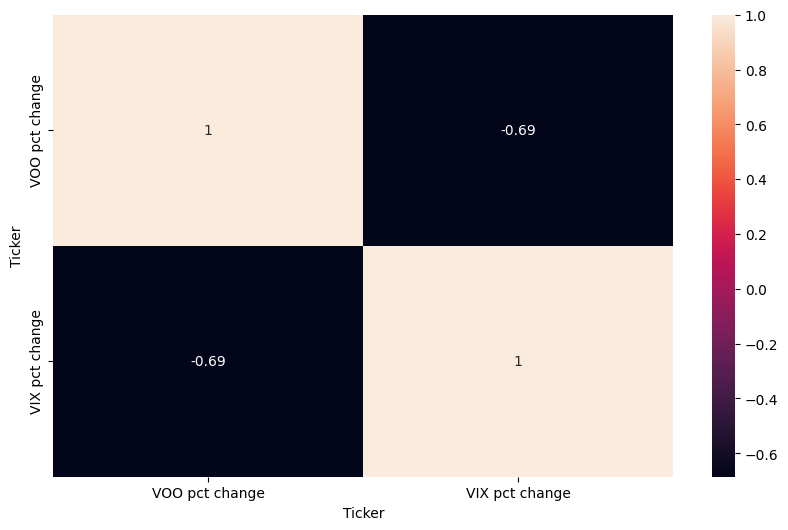

In [ ]:
#Plot correlation matrix for all variables
plt.figure(figsize=(10,6))
c = df_returns.corr()
sns.heatmap(c, annot=True)
plt.show()

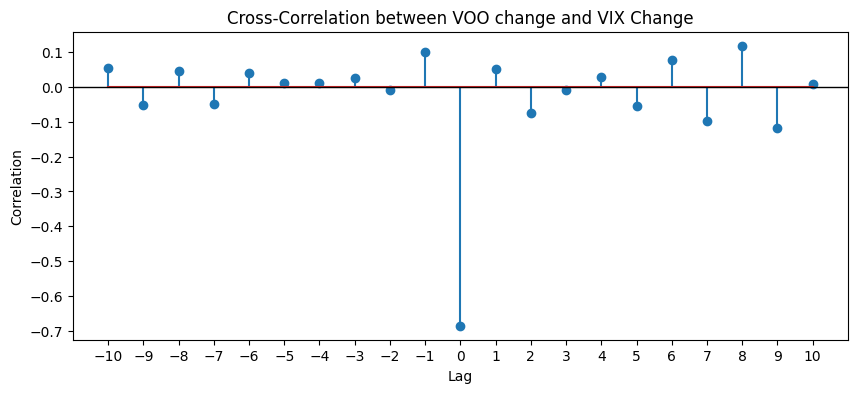

In [ ]:
max_lag = 10

# Calculate cross-correlation
lags = np.arange(-10, 11)
cross_corrs = [df_returns['VOO pct change'].corr(df_returns['VIX pct change'].shift(lag)) for lag in lags]

# Plot cross-correlation
plt.figure(figsize=(10, 4))
plt.stem(lags, cross_corrs)
plt.axhline(0, color='black', lw=1)
plt.xticks(np.arange(-max_lag, max_lag + 1, 1))
plt.title('Cross-Correlation between VOO change and VIX Change')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

# Feature Engineering

In [ ]:
df_signal                = df
df_signal['VIX SMA 20']  = df_signal['^VIX'].rolling(20).mean()
df_signal['buy signal']  = df_signal['^VIX'] < df_signal['VIX SMA 20']
df_signal['sell signal'] = df_signal['^VIX'] > df_signal['VIX SMA 20']
print(df_signal.tail())

Ticker             VOO       ^VIX  VIX SMA 20  buy signal  sell signal
Date                                                                  
2024-12-23  545.299500  16.780001     15.4900       False         True
2024-12-24  550.910034  14.270000     15.4735        True        False
2024-12-26  550.900024  14.730000     15.5050        True        False
2024-12-27  545.189880  15.950000     15.5975       False         True
2024-12-30  539.120850  17.400000     15.7920       False         True
Ticker             VOO       ^VIX  VIX SMA 20  buy signal  sell signal
Date                                                                  
2024-12-23  545.299500  16.780001     15.4900       False         True
2024-12-24  550.910034  14.270000     15.4735        True        False
2024-12-26  550.900024  14.730000     15.5050        True        False
2024-12-27  545.189880  15.950000     15.5975       False         True
2024-12-30  539.120850  17.400000     15.7920       False         True


# RSI

In [ ]:
df_RSI                      = df
df_RSI ['VOO RSI 7']        = RSIIndicator(close = df['VOO'], window =7).rsi()
df_RSI ['VIX RSI 7']        = RSIIndicator(close = df['^VIX'], window =7).rsi()
df_RSI ['VOO RSI 14']       = RSIIndicator(close = df['VOO'], window =14).rsi()
df_RSI ['VIX RSI 14']       = RSIIndicator(close = df['^VIX'], window =14).rsi()
df_RSI ['VOO RSI 35']       = RSIIndicator(close = df['VOO'], window =35).rsi()
df_RSI ['VIX RSI 35']       = RSIIndicator(close = df['^VIX'], window =35).rsi()
df_RSI ['VOO RSI 7 - 35']   = df_RSI ['VOO RSI 7'] - df_RSI ['VOO RSI 35']
df_RSI ['VIX RSI 7 - 35']   = df_RSI ['VIX RSI 7'] - df_RSI ['VIX RSI 35']
df_RSI                      = df_RSI[['VOO RSI 7','VIX RSI 7','VOO RSI 14','VIX RSI 14','VOO RSI 35','VIX RSI 35','VOO RSI 7 - 35','VIX RSI 7 - 35']]
print(df_RSI.tail())

Ticker      VOO RSI 7  VIX RSI 7  VOO RSI 14  VIX RSI 14  VOO RSI 35  \
Date                                                                   
2024-12-23  48.212106  48.004963   50.264929   50.275856   55.120780   
2024-12-24  58.206916  41.527955   55.984125   45.559494   57.411752   
2024-12-26  58.183543  43.167470   55.971759   46.549118   57.406370   
2024-12-27  45.913442  47.704590   49.283813   49.187320   54.411059   
2024-12-30  36.395993  52.916607   43.354373   52.206669   51.472601   

Ticker      VIX RSI 35  VOO RSI 7 - 35  VIX RSI 7 - 35  
Date                                                    
2024-12-23   49.915879       -6.908675       -1.910917  
2024-12-24   47.343191        0.795164       -5.815236  
2024-12-26   47.850267        0.777173       -4.682797  
2024-12-27   49.186222       -8.497616       -1.481632  
2024-12-30   50.730464      -15.076609        2.186143  


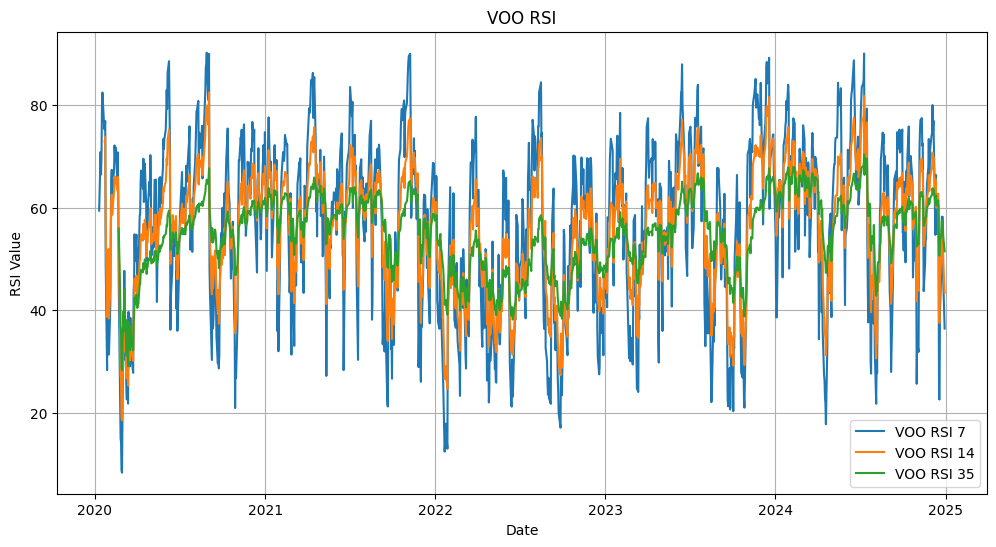

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_RSI.index, df_RSI['VOO RSI 7'], label='VOO RSI 7')
plt.plot(df_RSI.index, df_RSI['VOO RSI 14'], label='VOO RSI 14')
plt.plot(df_RSI.index, df_RSI['VOO RSI 35'], label='VOO RSI 35')
plt.xlabel('Date')
plt.ylabel('RSI Value')
plt.title('VOO RSI')
plt.legend()
plt.grid(True)
plt.show()


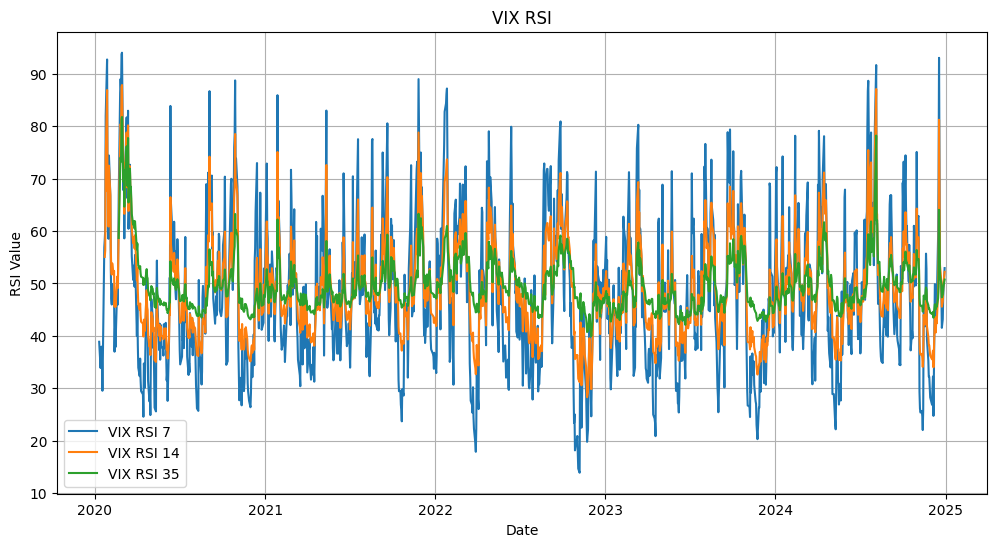

In [ ]:

plt.figure(figsize=(12, 6))
plt.plot(df_RSI.index, df_RSI['VIX RSI 7'], label='VIX RSI 7')
plt.plot(df_RSI.index, df_RSI['VIX RSI 14'], label='VIX RSI 14')
plt.plot(df_RSI.index, df_RSI['VIX RSI 35'], label='VIX RSI 35')
plt.xlabel('Date')
plt.ylabel('RSI Value')
plt.title('VIX RSI')
plt.legend()
plt.grid(True)
plt.show()


# Trading Strategy based on VIX level

In [ ]:
def backtest(df):
  df['Position'] = 0  # Initialize a column to track positions (0: no position, 1: long)

  # Loop through the data to generate signals
  # Use df.index to access rows by their actual index values (dates)
  for i in df.index[1:]:  # Start from the second row to avoid issues with previous values
      if df.loc[i,'buy signal'] == True : # Access the previous row's 'Position' using index location
          df.loc[i,'Position'] = 1
      elif df.loc[i,'sell signal'] == True : # Access the previous row's 'Position' using index location
          df.loc[i,'Position'] = -1
      else:
          df.loc[i,'Position'] = df.loc[df.index[df.index.get_loc(i) - 1],'Position'] # Access the previous row's 'Position' using index location

  # Calculate daily returns based on the strategy
  df['Strategy_Returns'] = df['VOO'].pct_change() * df['Position'].shift(1) #shift because we enter a position at the end of the day
  df['Strategy_Returns'] = df['Strategy_Returns'].fillna(0) #first day will be Nan

  # Calculate cumulative returns for the strategy and the benchmark
  df['Cumulative_Strategy_Returns'] = (1 + df['Strategy_Returns']).cumprod()
  df['Cumulative_VOO_Returns'] = (1 + df['VOO'].pct_change()).cumprod()

  # Plot cumulative returns
  plt.figure(figsize=(12, 6))
  plt.plot(df.index, df['Cumulative_Strategy_Returns'], label='Strategy Returns')
  plt.plot(df.index, df['Cumulative_VOO_Returns'], label='Buy and Hold VOO')
  plt.xlabel('Date')
  plt.ylabel('Cumulative Returns')
  plt.title('Backtest Results')
  plt.legend()
  plt.grid(True)
  plt.show()

  # Evaluate Performance (example metrics)
  strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
  buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100
  print(f"Total Strategy Return: {strategy_total_return:.2f}%")
  print(f"Total Buy and Hold VOO Return: {buy_and_hold_total_return:.2f}%")

  #Further analysis can include metrics like Sharpe ratio, Maximum Drawdown etc.

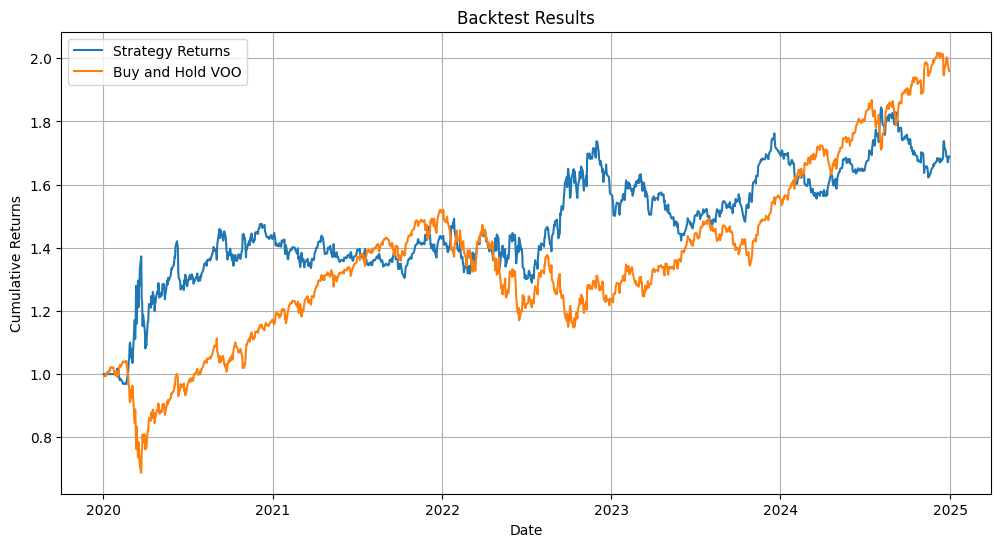

Total Strategy Return: 68.92%
Total Buy and Hold VOO Return: 95.93%


<ipython-input-22-a0b311fe58cc>:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
<ipython-input-22-a0b311fe58cc>:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100


In [ ]:
backtest(df)

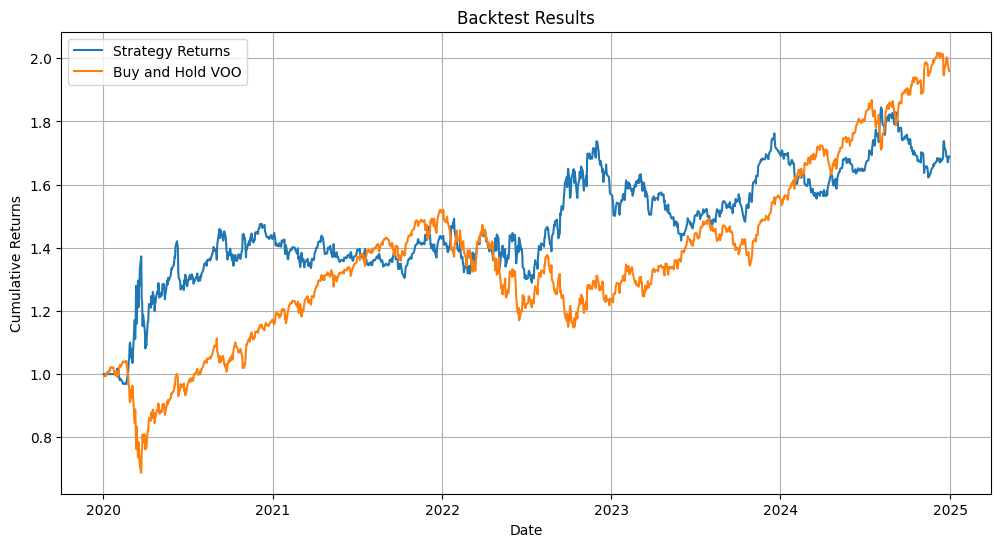

Total Strategy Return: 68.92%
Total Buy and Hold VOO Return: 95.93%


<ipython-input-28-836dbad94dd8>:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
<ipython-input-28-836dbad94dd8>:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100


In [ ]:
df['Position'] = 0  # Initialize a column to track positions (0: no position, 1: long)

# Loop through the data to generate signals
# Use df.index to access rows by their actual index values (dates)
for i in df.index[1:]:  # Start from the second row to avoid issues with previous values
    if df.loc[i,'buy signal'] == True : # Access the previous row's 'Position' using index location
        df.loc[i,'Position'] = 1
    elif df.loc[i,'sell signal'] == True : # Access the previous row's 'Position' using index location
        df.loc[i,'Position'] = -1
    else:
        df.loc[i,'Position'] = df.loc[df.index[df.index.get_loc(i) - 1],'Position'] # Access the previous row's 'Position' using index location

# Calculate daily returns based on the strategy
df['Strategy_Returns'] = df['VOO'].pct_change() * df['Position'].shift(1) #shift because we enter a position at the end of the day
df['Strategy_Returns'] = df['Strategy_Returns'].fillna(0) #first day will be Nan

# Calculate cumulative returns for the strategy and the benchmark
df['Cumulative_Strategy_Returns'] = (1 + df['Strategy_Returns']).cumprod()
df['Cumulative_VOO_Returns'] = (1 + df['VOO'].pct_change()).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Cumulative_Strategy_Returns'], label='Strategy Returns')
plt.plot(df.index, df['Cumulative_VOO_Returns'], label='Buy and Hold VOO')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Backtest Results')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate Performance (example metrics)
strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100
print(f"Total Strategy Return: {strategy_total_return:.2f}%")
print(f"Total Buy and Hold VOO Return: {buy_and_hold_total_return:.2f}%")

#Further analysis can include metrics like Sharpe ratio, Maximum Drawdown etc.

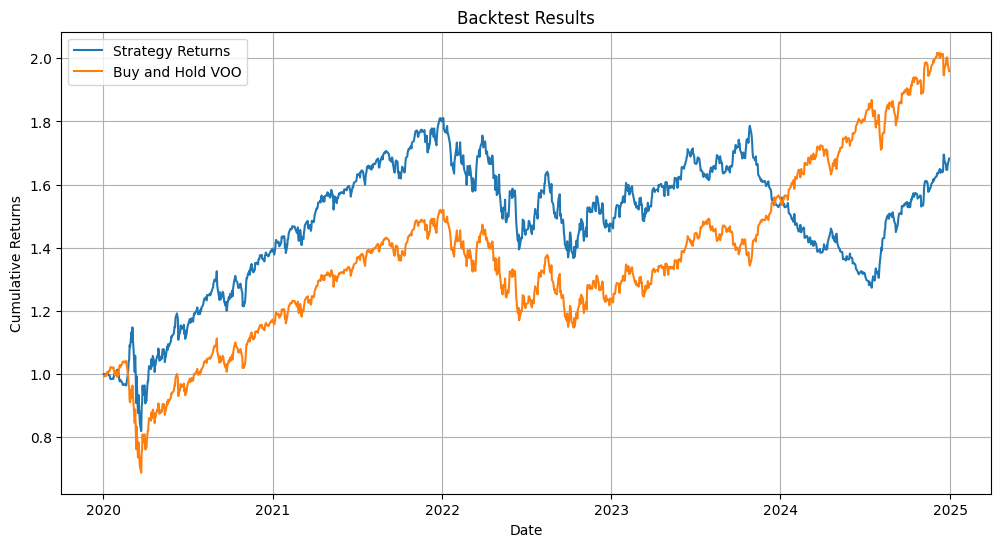

Total Strategy Return: 68.22%
Total Buy and Hold VOO Return: 95.93%


<ipython-input-16-71f3f514cf3b>:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
<ipython-input-16-71f3f514cf3b>:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100


In [ ]:
df['Position'] = 0  # Initialize a column to track positions (0: no position, 1: long)

# Loop through the data to generate signals
# Use df.index to access rows by their actual index values (dates)
for i in df.index[1:]:  # Start from the second row to avoid issues with previous values
    if df.loc[i,'^VIX'] > regime_1_vix_mean : # Access the previous row's 'Position' using index location
        df.loc[i,'Position'] = 1
    elif df.loc[i,'^VIX'] < regime_0_vix_mean : # Access the previous row's 'Position' using index location
        df.loc[i,'Position'] = -1
    else:
        df.loc[i,'Position'] = df.loc[df.index[df.index.get_loc(i) - 1],'Position'] # Access the previous row's 'Position' using index location

# Calculate daily returns based on the strategy
df['Strategy_Returns'] = df['VOO'].pct_change() * df['Position'].shift(1) #shift because we enter a position at the end of the day
df['Strategy_Returns'] = df['Strategy_Returns'].fillna(0) #first day will be Nan

# Calculate cumulative returns for the strategy and the benchmark
df['Cumulative_Strategy_Returns'] = (1 + df['Strategy_Returns']).cumprod()
df['Cumulative_VOO_Returns'] = (1 + df['VOO'].pct_change()).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Cumulative_Strategy_Returns'], label='Strategy Returns')
plt.plot(df.index, df['Cumulative_VOO_Returns'], label='Buy and Hold VOO')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Backtest Results')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate Performance (example metrics)
strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100
print(f"Total Strategy Return: {strategy_total_return:.2f}%")
print(f"Total Buy and Hold VOO Return: {buy_and_hold_total_return:.2f}%")


# Trading Strategy based on VIX RSI

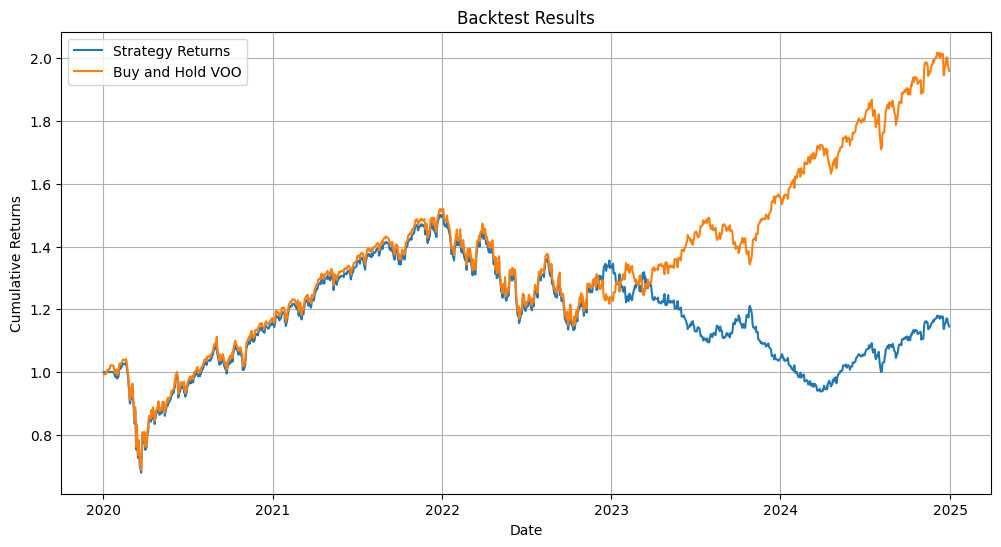

Total Strategy Return: 14.56%
Total Buy and Hold VOO Return: 95.93%


<ipython-input-17-cb30893327a5>:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
<ipython-input-17-cb30893327a5>:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100


In [ ]:
# prompt: Create the strategy to buy VOO when VIX is higher than 30 and sell VOO when VIX is lower than 15. Backtest the strategy

df['Position'] = 0  # Initialize a column to track positions (0: no position, 1: long)
df['Buy_Signal'] = 0

# Loop through the data to generate signals
# Use df.index to access rows by their actual index values (dates)
for i in df.index[1:]:  # Start from the second row to avoid issues with previous values
    if df_RSI.loc[i,'VIX RSI 14']  > 70 : # Access the previous row's 'Position' using index location
        df.loc[i,'Position'] = 1
    elif df_RSI.loc[i,'VIX RSI 14'] < 30 : # Access the previous row's 'Position' using index location
        df.loc[i,'Position'] = -1
    else:
        df.loc[i,'Position'] = df.loc[df.index[df.index.get_loc(i) - 1],'Position'] # Access the previous row's 'Position' using index location

# Calculate daily returns based on the strategy
df['Strategy_Returns'] = df['VOO'].pct_change() * df['Position'].shift(1) #shift because we enter a position at the end of the day
df['Strategy_Returns'] = df['Strategy_Returns'].fillna(0) #first day will be Nan

# Calculate cumulative returns for the strategy and the benchmark
df['Cumulative_Strategy_Returns'] = (1 + df['Strategy_Returns']).cumprod()
df['Cumulative_VOO_Returns'] = (1 + df['VOO'].pct_change()).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Cumulative_Strategy_Returns'], label='Strategy Returns')
plt.plot(df.index, df['Cumulative_VOO_Returns'], label='Buy and Hold VOO')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Backtest Results')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate Performance (example metrics)
strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100
print(f"Total Strategy Return: {strategy_total_return:.2f}%")
print(f"Total Buy and Hold VOO Return: {buy_and_hold_total_return:.2f}%")


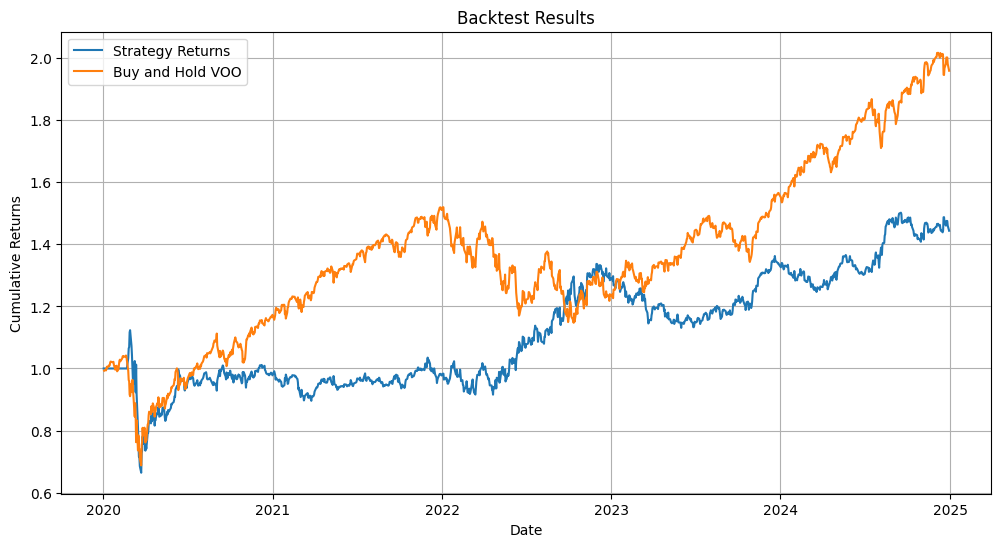

Total Strategy Return: 44.38%
Total Buy and Hold VOO Return: 95.93%


<ipython-input-51-2a5a3e47a964>:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
<ipython-input-51-2a5a3e47a964>:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100


In [ ]:
# prompt: Create the strategy to buy VOO when VIX is higher than 30 and sell VOO when VIX is lower than 15. Backtest the strategy

df['Position'] = 0  # Initialize a column to track positions (0: no position, 1: long)
df['Buy_Signal'] = 0

# Loop through the data to generate signals
# Use df.index to access rows by their actual index values (dates)
for i in df.index[1:]:  # Start from the second row to avoid issues with previous values
    if df_RSI.loc[i,'VIX RSI 7 - 35']  < 0 : # Access the previous row's 'Position' using index location
        df.loc[i,'Position'] = 1
    elif df_RSI.loc[i,'VIX RSI 7 - 35'] > 0 : # Access the previous row's 'Position' using index location
        df.loc[i,'Position'] = -1
    else:
        df.loc[i,'Position'] = df.loc[df.index[df.index.get_loc(i) - 1],'Position'] # Access the previous row's 'Position' using index location

# Calculate daily returns based on the strategy
df['Strategy_Returns'] = df['VOO'].pct_change() * df['Position'].shift(1) #shift because we enter a position at the end of the day
df['Strategy_Returns'] = df['Strategy_Returns'].fillna(0) #first day will be Nan

# Calculate cumulative returns for the strategy and the benchmark
df['Cumulative_Strategy_Returns'] = (1 + df['Strategy_Returns']).cumprod()
df['Cumulative_VOO_Returns'] = (1 + df['VOO'].pct_change()).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Cumulative_Strategy_Returns'], label='Strategy Returns')
plt.plot(df.index, df['Cumulative_VOO_Returns'], label='Buy and Hold VOO')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Backtest Results')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate Performance (example metrics)
strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100
print(f"Total Strategy Return: {strategy_total_return:.2f}%")
print(f"Total Buy and Hold VOO Return: {buy_and_hold_total_return:.2f}%")
